<a href="https://colab.research.google.com/github/pradeepsamm/stocks/blob/main/Amazon_Stock%20predication_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [ ]:
df = pd.read_csv("./Databases/AmazonStockPrices/AMZNtrain.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,398.799988,399.359985,394.019989,397.970001,397.970001,2137800
1,2014-01-03,398.290009,402.709991,396.220001,396.440002,396.440002,2210200
2,2014-01-06,395.850006,397.000000,388.420013,393.630005,393.630005,3170600
3,2014-01-07,395.040009,398.470001,394.290009,398.029999,398.029999,1916000
4,2014-01-08,398.470001,403.000000,396.040009,401.920013,401.920013,2316500


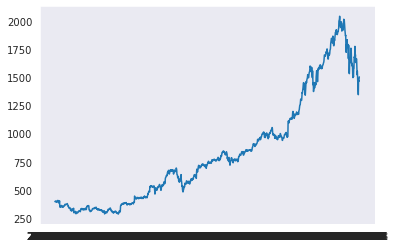

In [ ]:
x = df['Date']
y = df['Close']
sns.set_style("dark")
plt.plot(x, y)

In [ ]:
price = df[['Close']]

scaler = MinMaxScaler(feature_range=(-1,1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

/tmp/ipykernel_27469/3422120305.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


In [ ]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]

lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [ ]:
import torch
import torch.nn as nn

In [ ]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = True)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.5399134159088135
Epoch  1 MSE:  0.36458873748779297
Epoch  2 MSE:  0.17374257743358612
Epoch  3 MSE:  0.07232511043548584
Epoch  4 MSE:  0.17428749799728394
Epoch  5 MSE:  0.0851665735244751
Epoch  6 MSE:  0.06653928756713867
Epoch  7 MSE:  0.08550455421209335
Epoch  8 MSE:  0.09806451201438904
Epoch  9 MSE:  0.09608735889196396
Epoch  10 MSE:  0.08408394455909729
Epoch  11 MSE:  0.0691225677728653
Epoch  12 MSE:  0.05813386291265488
Epoch  13 MSE:  0.055644262582063675
Epoch  14 MSE:  0.060322556644678116
Epoch  15 MSE:  0.06340453028678894
Epoch  16 MSE:  0.056806180626153946
Epoch  17 MSE:  0.04312429577112198
Epoch  18 MSE:  0.03133068606257439
Epoch  19 MSE:  0.026496490463614464
Epoch  20 MSE:  0.02424217388033867
Epoch  21 MSE:  0.015078178606927395
Epoch  22 MSE:  0.0031669752206653357
Epoch  23 MSE:  0.006960354279726744
Epoch  24 MSE:  0.014623373746871948
Epoch  25 MSE:  0.013974232599139214
Epoch  26 MSE:  0.011416187509894371
Epoch  27 MSE:  0.009411734528

In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

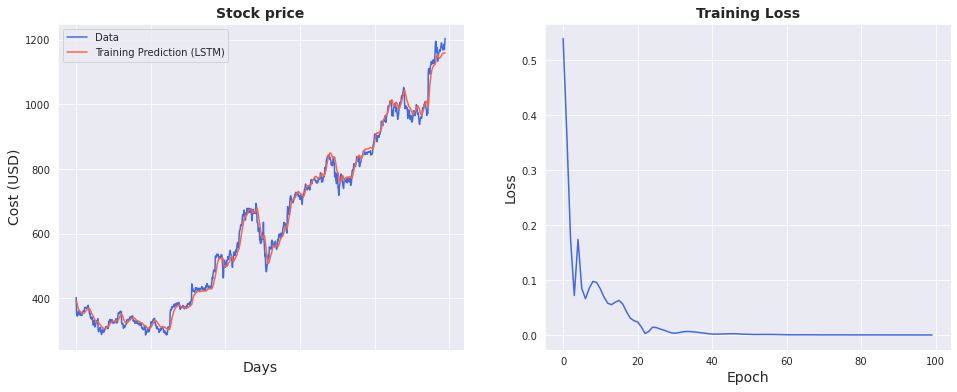

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)
